**Навигация по уроку**

1. [Краткая история нейронных сетей. Знакомство с многослойным персептроном](https://colab.research.google.com/drive/1-FEYLgNSN5kJyAOoaW9dOhDUABU8VJlc)
2. [Математический аппарат обучения нейронных сетей](https://colab.research.google.com/drive/1FtyyBXYq9FaOEknvu4ghim-ejuO_3aIZ)
3. [Обучение многослойного персептрона в TensorFlow (Практика)](https://colab.research.google.com/drive/1Q8ioc9pkkaqGravu37C7jKw9OaG7cNL0)
4. Домашняя работа

Используя модель обучения многослойного персептрона из практической части урока (9.3), выполните следующее:

1. Увеличьте число слоев до 4-х и сравните время обучения модели и точность на тестовой выборке.
2. В качестве датасета использовать любой из наборов данных TensorFlow. Обучить модель. Добейтесь результата распознования более 85% на тестовой выборке. [Датасеты на выбор](https://www.tensorflow.org/datasets/overview). Используйте датасет отличный от MNIST, который был в уроке.

Для прохождения урока достаточно решить первое задание.

In [ ]:
#Напишите свое решение

**Для реализации задачи 2 возьмем датасет  IMDB Reviews**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import pandas as pd

#Загрузка сета

In [ ]:
ds, info = tfds.load('imdb_reviews', split='train', with_info=True)

In [ ]:
tfds.as_dataframe(ds.take(1), info)

,label,text
0,0 (neg),"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
    

Датасет состоит из лейбла (0 для плохого отзыва и 1 для хорошего) и текстового отзыва. Для дальнейшей работы понадобится предобработка данного датасета. С другой стороны `tf.keras.datasets.imdb.load_data` предоставляет тот же датасет уже обработанный и приведенный в числовой формат, где каждое слово является индексом:

In [ ]:
ds2 = tf.keras.datasets.imdb.load_data()

In [ ]:
ds2[0]

(array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
        list([1, 194,

Воспользуемся вторым вариантом, ограничив словарь 10000 наиболее используемыми словами (в данном случае индексами)

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

In [ ]:
x_train.shape, x_test.shape

((25000,), (25000,))

#Предобработка данных

Так как отзывы разной длинны, нам нужно унифицировать их, например, ограничив их 500 **словами** (не путать с символами)

Для этого воспользуемся **`tf.keras.preprocessing.sequence.pad_sequences`**. Она обрезает указанный список, если он длинне `maxlen`, или дополняет его нулям, если он короче. По умолчанию обрезка или дополнение идет с начала списка. Задать другие параметры можно с помощью **`padding='pre'/'post'`** (дополнение с начала / с конца) и **`truncating='pre'/'post'`**(обрезка с начала / с конца)

In [ ]:
maxlen=500
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

#Создание модели

Используем модель **Sequential**, которая является последовательной, без создания обратных связей.

Наша модель будет состоять из следующих слоев:
1. Первый слой **Embedding**, который преобразует входные данные отзыва, обрабатывая слова в нем.
- **`input_dim`** - размерность входного пространства, в нашем случае это 10000 наиболее используемых слов
- **`output_dim`** - задает размерность выходного вектора для каждого слова, зададим 128, т.е. каждое слово будет представлено вектором из 128 элементов
- **`input_lenght`** - длинна пакета данных на входе, т.е. 500 слов, которые мы задали ранее. (этот параметр можно опустить)
- на выходе слоя мы получаем матрицу векторов для отзыва размерностью (500, 128)
2. Второй слой **Flatten** служит для вытягивания матрицы слоя **Embedding** в один вектор, чтобы передать его дальше на плотные слои **Dense**. Имеет вид 500*128=64000, т.е. (64000, )
3. Плотный слой **Dense** с 128 нейронами, активация ReLU
4. Плотный слой **Dense** с 64 нейронами, активация ReLU
5. Плотный слой **Dense** с 1 нейроном, активация sigmoid.
- Этот слой на выходе будет показывать, какой именно характер носит отзыв. Если вероятность **p** будет ближе к 1, то модель предскажет положительный отзыв, если к 0 то отрицательный. Для классификации из 2х вариантов сигмоида является лучшим выбором.

In [ ]:
mlp = models.Sequential([
    layers.Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

#Компиляция модели
Используем метод **compile**, который принимает следующие параметры:
- **optimizer** - выбираем метод оптимизации, чаще всего используется `Adam`, но таже есть SGD (стохастический градиентный спуск), RMSProp и другие.
- **loss** - выбираем функцию потерь, в нашем случае это `binary_crossentropy`, когда варианта на выходе всего 2
- **metrics** - выбираем местрики для нашей модели, в нашем случае `accuracy`

In [ ]:
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

можем проверить параметры скомпилированной модели с помощью метода **.summary()**.

In [ ]:
mlp.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

В первый вызов **.sumary()**, когда модель еще не использовалась, мы получим таблицу с параметрами unbuilt. Это значит, что наша модель еще не построена. Она строится либо с помощью метода **.build(input_shape=(None, 500))** с указанием размерности входа, либо нужно передать в нее пакет данных, например, первый отзыв в датасете через предсказание **.predict(x_train[:1])**

In [ ]:
mlp.build(input_shape=(None, 500))

In [ ]:
mlp.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 500, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 64000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       8,192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,480,449 (36.17 MB)

 Trainable params: 9,480,449 (36.17 MB)

 Non-trainable params: 0 (0.00 B)

Теперь мы можем видеть нашу модель с характеристиками. Всего в ней будет настраиваться 9,5 млн параметров.

**None** в **Output Shape** означает, что размер пакета (batch size) не фиксирован и может изменяться в зависимости от того, сколько образцов мы подаем в модель за один раз. Это позволяет модели быть гибкой и обрабатывать данные в пакетах разного размера.

#Обучение модели
для обучения модели используем метод **.fit**, который принимает следующие параметры:
(`учебные данные`, `метки учебных данных`, `epochs=`эпохи, `batch_size=`размер пакета(после которого обновляются веса), `validation_data=`данные для проверки эффективности модели(на тех данных, которых она не видела в обучении))

In [ ]:
train = mlp.fit(x_train, y_train, epochs=10, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5271 - loss: 0.7620 - val_accuracy: 0.7768 - val_loss: 0.5094
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8314 - loss: 0.3935 - val_accuracy: 0.8667 - val_loss: 0.3150
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9282 - loss: 0.1912 - val_accuracy: 0.8815 - val_loss: 0.2813
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9709 - loss: 0.0969 - val_accuracy: 0.8772 - val_loss: 0.3106
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9937 - loss: 0.0358 - val_accuracy: 0.8736 - val_loss: 0.3753
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9989 - loss: 0.0086 - val_accuracy: 0.8714 - val_loss: 0.4356
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 0.8723 - val_loss: 0.4755
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 1.0000 - loss: 6.7925e-04 - val_accuracy: 0.8728 - val_l

Обучение заняло примерно 12 минут, без использования ресурсов GPU (сработало ограничение colab)

#Оценка модели


In [ ]:
test_loss, test_acc = mlp.evaluate(x_test, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8708 - loss: 0.5436


In [ ]:
print(f'Точность модели {test_acc*100:.2f}%')

Точность модели 87.28%


Посмотрим график точности. Для извлечения точности из каждой эпохи воспользуемся методом **.history**

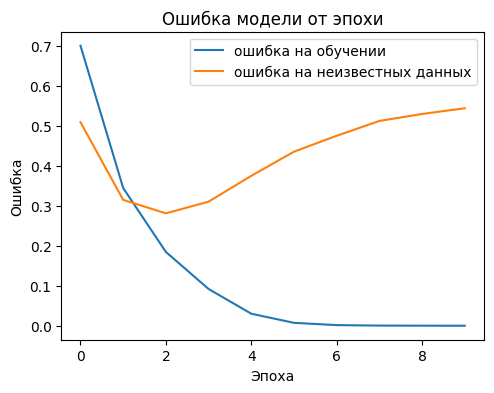

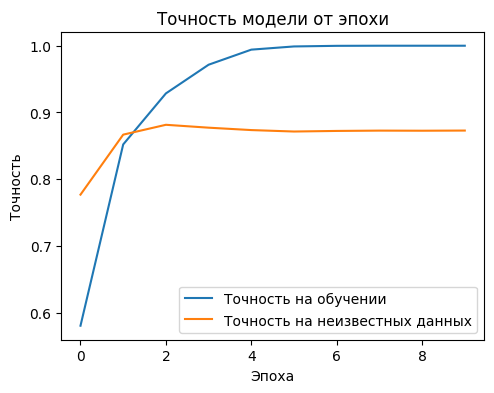

In [ ]:
import matplotlib.pyplot as plt

loss=train.history['loss']
val_loss=train.history['val_loss']
acc=train.history['accuracy']
val_acc=train.history['val_accuracy']

#графики потерь
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='ошибка на обучении')
plt.plot(val_loss, label='ошибка на неизвестных данных')
plt.title('Ошибка модели от эпохи')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()

#график точности
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(acc, label='Точность на обучении')
plt.plot(val_acc, label='Точность на неизвестных данных')
plt.title('Точность модели от эпохи')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.show()

На графике Ошибок четко видна впадина на 2 эпохе, и после нее график начал подинматься. Это говорит, что модель стала подстраиваться под тренировочне данные и терять точность на данных, которых она не видела.

Данное поведение говорит о последующем ухудшении возможности модели обобщать предсказания на неизвестных данных.

На графике точности прямая точности на валидационных данных после 2 эпохи притяла почти горизонтальную линию, что так же свидетельствует о торможении обучения модели.

#Сохранение весов из конкретной эпохи

В случае, когда модель переобучается, и возникает необходимость загружать веса и смещения из промежуточной эпохи, на помощь придет **`ModelCheckpoint`**.

используется следующим образом:

In [ ]:
from keras.callbacks import ModelCheckpoint

#указываем путь сохранения
checkpoint_filepath = 'best_model.h5'

#создание вызова
checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                             monitor = 'val_loss',
                             save_best_only = True,
                             mode = 'min')

- **`monitor`** - что отслеживаем, можно так же указать **`val_accuracy`**
- **`mode`** - какое значение сохранять, для **`val_accuracy`** указывается **`max`**

Применяется во время обучения модели следующим образом:

In [ ]:
train = mlp.fit(x_train, y_train, epochs=10, batch_size=512, validation_data=(x_test, y_test), callbacks=[checkpoint])

После сохранения, мы можем использовать веса в этой или любой другой модели, используюя метод **.load_weights(checkpoint_filepath)**

#Использование модели для предсказания на неизвестных данных

Для предсказания используется метод **.predict(new_data)**

Т.к. новых данных у нас пока не имеется, только датасет из TensorFlow, оставим это на будущие работы)

In [ ]:
predictions = mlp.predict(new_data)